# Captcha Data Cleaning and EDA

### Imports

In [1]:
import string
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline 

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
tf.__version__, cv2.__version__

('2.1.0', '4.2.0')

## Data Cleaning

### Load Data

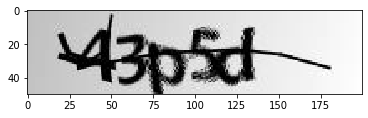

In [5]:
# example from 1000 image dataset
simg=cv2.imread('data/s_data/43p5d.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(simg, cmap=plt.get_cmap('gray'))

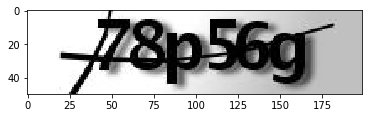

In [6]:
# example from AWS website
img=cv2.imread('trial.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

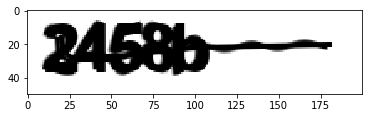

In [7]:
# example from 100,000 image dataset 
img=cv2.imread('data/l_data/2458b.png', cv2.IMREAD_UNCHANGED)[:,:,3]

# remove border 
img[[0,49],1:199] -= 255
img[:,0] -= 255
img[:,199] -= 255

plt.imshow(img, cmap=plt.cm.binary)

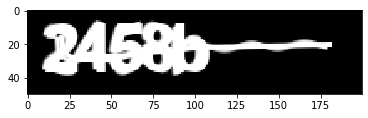

In [8]:
# for anti grayscale
img=cv2.imread('data/l_data/2458b.png',cv2.IMREAD_UNCHANGED)
a = img[:,:,3]
lst = []

for i in a.flatten():
    lst.append(np.abs(i - 255))
lst = np.array(lst)
img = lst.reshape(50, 200)

img[[0,49],1:199] += 255
img[:,0] += 255
img[:,199] += 255

plt.imshow(img, cmap=plt.cm.binary)

### Removing Border and Create Target

In [9]:
# check data folders for non image files
def s_data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/s_data/'
    else:
        path = 'data/s_data/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png' or name[-4:] == '.jpg':
            pass
        else:
            print(name)
        
def l_data_check(from_src=False):
    '''Check for non PNG files
    '''
    if from_src:
        path = '../data/l_data/'
    else:
        path = 'data/l_data/'
        
    for name in os.listdir(path):
        if name[-4:] == '.png':
            pass
        else:
            print(name)

In [10]:
s_data_check() # should not print anything

In [11]:
l_data_check() # should not print anything

In [12]:
len(os.listdir('data/l_data'))

109053

In [13]:
chars = string.ascii_lowercase + "0123456789"
num_chars = len(chars)

In [14]:
# image data processing functions

def remove_img_border(img):
    # remove border
    img[[0,49],1:199] -= 255
    img[:,0] -= 255
    img[:,199] -= 255
    
    return img
    
def l_data_process(from_src=False):
    '''Processes the l_data folder of 109,053 images 
    Parameters:
    -----------
    from_src: True if function is run from src folder
    
    Returns:
    X: 4 tensor numpy array of image data
    y: One hot encoded targets
    labels: labels for image data
    '''
    if from_src:
        path = '../data/l_data/'
    else:
        path = 'data/l_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars)) 
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,3]
        
        img = remove_img_border(img)
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

def s_data_process(from_src=False):
    '''Processes the s_data folder of 1070 images 
    Parameters:
    -----------
    from_src: True if function is run from src folder
    
    Returns:
    X: 4 tensor numpy array of image data
    y: One hot encoded targets
    labels: labels for image data
    '''
    if from_src:
        path = '../data/s_data/'
    else:
        path = 'data/s_data/'
        
    X = np.zeros((len(os.listdir(path)), 50, 200, 1)) 
    y = np.zeros((5, len(os.listdir(path)), num_chars))
    labels = []
    
    for i, name in enumerate(os.listdir(path)):
        img_path = path + name
        img = cv2.imread(img_path , cv2.IMREAD_GRAYSCALE)
        
        img = img / 255.0
        img = img.reshape(50, 200, 1)
        
        # Define labels using OneHotEncoding
        label = name[:-4]
        target = np.zeros((5, num_chars))
        for j, l in enumerate(label):
            ind = chars.find(l)
            target[j, ind] = 1
        
        X[i] = img
        y[:, i] = target
        labels.append(label)
   
    return X, y, labels

In [15]:
s_X, s_y, s_labels = s_data_process()
s_X.shape, s_y.shape

((1070, 50, 200, 1), (5, 1070, 36))

In [16]:
s_y[0].shape

(1070, 36)

In [17]:
X, y, llabels = l_data_process()
X.shape, y.shape

((109053, 50, 200, 1), (5, 109053, 36))

In [18]:
X[0].shape, y[:, 0].shape

((50, 200, 1), (5, 36))

In [19]:
# contours doesn't work with connected characters...

## Exploratory Data Analysis

In [23]:
slst_of_chars = []
for s in s_y:
    slst_of_chars += [char for char in s]
len(slst_of_chars)/1070, len(slst_of_chars)

(5.0, 5350)

In [24]:
#pd.Series(slst_of_chars).value_counts().sort_index();

In [27]:
lst_of_chars = []
for s in y:
    lst_of_chars += [char for char in s]
len(lst_of_chars)/109053, len(lst_of_chars)

(5.0, 545265)

In [ ]:
# Character Distribution for Large Image Dataset
pd.Series(lst_of_chars).value_counts().sort_index()

In [20]:
def remove_grid_lines(axs):
    """Remove the default grid lines from a collection of axies."""
    for ax in axs.flatten():
        ax.grid(False)

In [27]:
def apply_convolution_to_image(image,
                               image_shape=(50, 200),
                               filter_shape = (5, 5)):
    """Apply a convolutional filter to an image.  The inputs here should be
    numpy arrays, this function will take care of converting them to tensors
    and back.
    """

    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    #filter_tensor = convolutional_filter.reshape(filter_shape[0], filter_shape[1], 1, 1)
    
    
    x = layers.Input(shape=image_shape) # Get image as an input and process it through some Convs
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
    #x = layers.MaxPooling2D(padding='same')(x)
    
    image_convloved = x[0, :, :, 0]
    return image_convloved

In [28]:
def apply_max_pool_to_image(image, 
                            image_shape=(50,200), 
                            filter_shape = (2, 2)):
    image_tensor = image.reshape(1, image_shape[0], image_shape[1], 1)
    image_pooled_tensor = tf.nn.max_pool(
        image_tensor, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], padding='SAME')
    image_pooled = image_pooled_tensor[0, :, :, 0]
    return image_pooled

In [ ]:
# example from 100,000 image dataset 
img=cv2.imread('data/m_data/y223e.png', cv2.IMREAD_UNCHANGED)[:,:,3]

# remove border 
img = remove_img_border(img)
img = img / 255.0

blurred = apply_convolution_to_image(img)
pooled = apply_max_pool_to_image(img)

In [ ]:
def plot_convolution(before, after, axs):
    """Plot a 1 by 3 grid of images:
        - A before image.
        - A filter to apply.
        - The result of convolving the filter with the image.
    """
    axs[0].imshow(before, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[0].set_title("Before")
    axs[1].imshow(after, cmap=plt.cm.gray_r, interpolation="nearest")
    axs[1].set_title("After")

In [ ]:
blurred.shape, pooled.shape

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

plot_convolution(img, pooled, axs)
remove_grid_lines(axs)

# after Max Pooling

### Look at Layer Weights

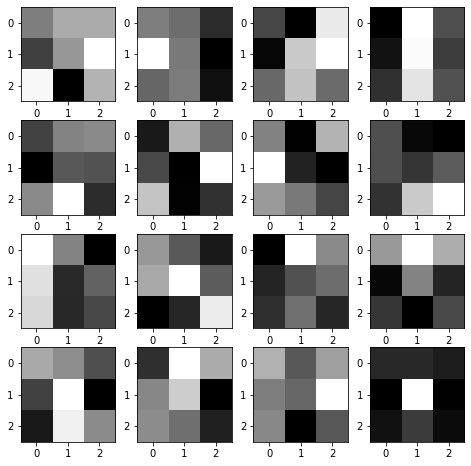

In [187]:
weights1_np = model.get_weights()[0] # 5 5 1 16

fig, axs = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    filter = weights1_np[:, :, 0, i]
    ax.imshow(filter, cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)

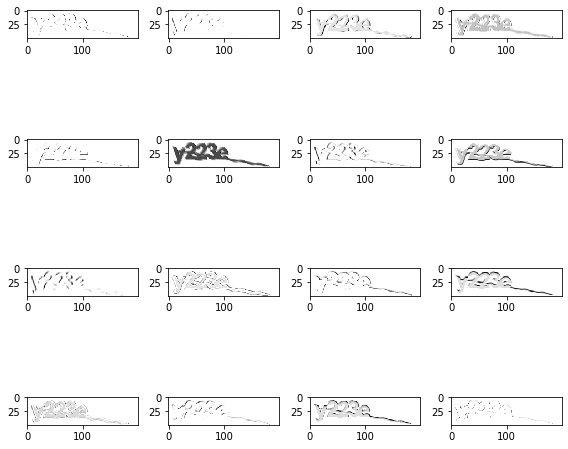

In [188]:
zero_tensor = tf.constant(img.reshape(1, 50, 200, 1))
zero_activations = tf.nn.conv2d(
    zero_tensor, weights1_np, strides=[1, 1, 1, 1], padding='SAME'
)
# or keras.activations.relu(zero_activations)
zero_activations_relu = np.maximum(zero_activations,0) 
# plot
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(zero_activations_relu[0, :, :, i],
              cmap=plt.cm.gray_r, interpolation="nearest")
remove_grid_lines(axs)
plt.tight_layout()

## Split Data

#### Small Image Dataset

In [30]:
s_X.shape, s_y.shape

((1070, 50, 200, 1), (5, 1070, 36))

In [31]:
sX_train, sy_train = s_X[:900], s_y[:, :900]
sX_test, sy_test = s_X[900:], s_y[:, 900:]

##### Try

In [ ]:
sX_train, sX_test, sy_train, sy_test = train_test_split(s_X, s_y, test_size=0.2, random_state=7)

In [37]:
sX_train.shape, sX_test.shape, sy_train.shape, sy_test.shape

((856, 50, 200), (214, 50, 200), (856,), (214,))

In [38]:
sX_train[0].shape

(50, 200)

#### Large Image Dataset

In [32]:
X.shape, y.shape

((109053, 50, 200, 1), (5, 109053, 36))

In [33]:
X_train, y_train = X[:77777], y[:, :77777]
X_test, y_test = X[77777:88888], y[:, 77777:88888]
Xer, yer = X[88888:], y[:, 88888:]

##### Try

In [74]:
lX_train, lX_test, ly_train, ly_test = train_test_split(l_X, l_y, test_size=0.2, random_state=7)

In [41]:
lX_train.shape, lX_test.shape, ly_train.shape, ly_test.shape

((71728, 50, 200), (17933, 50, 200), (71728,), (17933,))

In [42]:
lX_train[0].shape

(50, 200)

## Build Model

In [143]:
input_shape = (50, 200, 1)

# Input layer
imgm = layers.Input(shape=input_shape)

# Convolution and Max Pooling layers
cn1 = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(imgm)
mp1 = layers.MaxPooling2D(padding='same')(cn1)  

cn2 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(mp1)
mp2 = layers.MaxPooling2D(padding='same')(cn2)  

cn3 = layers.Conv2D(32, (5,5), padding='same', activation='relu')(mp2)
mp3 = layers.MaxPooling2D(padding='same')(cn3)   
 
cn4 = layers.Conv2D(16, (5, 5), padding='same', activation='relu')(mp3)
mp4 = layers.MaxPooling2D(padding='same')(cn4)  

# Flatten and Dense layers
flat = layers.Flatten()(mp4)
output = []
for _ in range(5):
    dens1 = layers.Dense(64, activation='relu')(flat)
    drop = layers.Dropout(0.5)(dens1)
    result = layers.Dense(num_chars, activation='sigmoid')(drop)

    output.append(result)

In [144]:
# Compile model
model = Model(imgm, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [145]:
model.summary();

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 50, 200, 16)  416         input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_45 (MaxPooling2D) (None, 25, 100, 16)  0           conv2d_46[0][0]                  
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 25, 100, 32)  12832       max_pooling2d_45[0][0]           
___________________________________________________________________________________________

In [146]:
X_train.shape

(77777, 50, 200, 1)

In [147]:
history = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
                 batch_size=64, epochs=50,verbose=1, validation_split=0.2)

Train on 62221 samples, validate on 15556 samples
Epoch 1/50
62221/62221 [==============================] - 33s 529us/sample - loss: 8.9166 - dense_121_loss: 1.1497 - dense_123_loss: 1.8176 - dense_125_loss: 2.0876 - dense_127_loss: 2.1338 - dense_129_loss: 1.7239 - dense_121_accuracy: 0.6291 - dense_123_accuracy: 0.3788 - dense_125_accuracy: 0.3027 - dense_127_accuracy: 0.2964 - dense_129_accuracy: 0.4242 - val_loss: 1.5992 - val_dense_121_loss: 0.0083 - val_dense_123_loss: 0.2486 - val_dense_125_loss: 0.5461 - val_dense_127_loss: 0.6147 - val_dense_129_loss: 0.1808 - val_dense_121_accuracy: 0.9974 - val_dense_123_accuracy: 0.9210 - val_dense_125_accuracy: 0.8181 - val_dense_127_accuracy: 0.7939 - val_dense_129_accuracy: 0.9487
Epoch 2/50
62221/62221 [==============================] - 30s 482us/sample - loss: 1.9142 - dense_121_loss: 0.0730 - dense_123_loss: 0.3256 - dense_125_loss: 0.6168 - dense_127_loss: 0.6446 - dense_129_loss: 0.2539 - dense_121_accuracy: 0.9757 - dense_123_accur

Epoch 13/50
62221/62221 [==============================] - 30s 482us/sample - loss: 0.1668 - dense_121_loss: 0.0108 - dense_123_loss: 0.0215 - dense_125_loss: 0.0544 - dense_127_loss: 0.0520 - dense_129_loss: 0.0281 - dense_121_accuracy: 0.9959 - dense_123_accuracy: 0.9925 - dense_125_accuracy: 0.9808 - dense_127_accuracy: 0.9814 - dense_129_accuracy: 0.9901 - val_loss: 0.0194 - val_dense_121_loss: 1.5348e-05 - val_dense_123_loss: 3.0403e-04 - val_dense_125_loss: 0.0086 - val_dense_127_loss: 0.0083 - val_dense_129_loss: 0.0021 - val_dense_121_accuracy: 1.0000 - val_dense_123_accuracy: 0.9999 - val_dense_125_accuracy: 0.9975 - val_dense_127_accuracy: 0.9971 - val_dense_129_accuracy: 0.9994
Epoch 14/50
62221/62221 [==============================] - 30s 482us/sample - loss: 0.1618 - dense_121_loss: 0.0111 - dense_123_loss: 0.0204 - dense_125_loss: 0.0494 - dense_127_loss: 0.0539 - dense_129_loss: 0.0271 - dense_121_accuracy: 0.9959 - dense_123_accuracy: 0.9930 - dense_125_accuracy: 0.9826

Epoch 25/50
62221/62221 [==============================] - 30s 481us/sample - loss: 0.0741 - dense_121_loss: 0.0055 - dense_123_loss: 0.0081 - dense_125_loss: 0.0196 - dense_127_loss: 0.0257 - dense_129_loss: 0.0151 - dense_121_accuracy: 0.9979 - dense_123_accuracy: 0.9972 - dense_125_accuracy: 0.9934 - dense_127_accuracy: 0.9911 - dense_129_accuracy: 0.9949 - val_loss: 0.0224 - val_dense_121_loss: 2.8070e-04 - val_dense_123_loss: 0.0023 - val_dense_125_loss: 0.0085 - val_dense_127_loss: 0.0090 - val_dense_129_loss: 0.0023 - val_dense_121_accuracy: 0.9999 - val_dense_123_accuracy: 0.9995 - val_dense_125_accuracy: 0.9983 - val_dense_127_accuracy: 0.9980 - val_dense_129_accuracy: 0.9992
Epoch 26/50
62221/62221 [==============================] - 30s 481us/sample - loss: 0.0723 - dense_121_loss: 0.0047 - dense_123_loss: 0.0083 - dense_125_loss: 0.0197 - dense_127_loss: 0.0253 - dense_129_loss: 0.0142 - dense_121_accuracy: 0.9983 - dense_123_accuracy: 0.9972 - dense_125_accuracy: 0.9933 - d

Epoch 37/50
62221/62221 [==============================] - 30s 481us/sample - loss: 0.0489 - dense_121_loss: 0.0039 - dense_123_loss: 0.0057 - dense_125_loss: 0.0130 - dense_127_loss: 0.0162 - dense_129_loss: 0.0101 - dense_121_accuracy: 0.9985 - dense_123_accuracy: 0.9979 - dense_125_accuracy: 0.9957 - dense_127_accuracy: 0.9945 - dense_129_accuracy: 0.9965 - val_loss: 0.0169 - val_dense_121_loss: 2.9581e-07 - val_dense_123_loss: 1.1868e-04 - val_dense_125_loss: 0.0058 - val_dense_127_loss: 0.0090 - val_dense_129_loss: 0.0019 - val_dense_121_accuracy: 1.0000 - val_dense_123_accuracy: 0.9999 - val_dense_125_accuracy: 0.9992 - val_dense_127_accuracy: 0.9985 - val_dense_129_accuracy: 0.9997
Epoch 38/50
62221/62221 [==============================] - 30s 481us/sample - loss: 0.0493 - dense_121_loss: 0.0039 - dense_123_loss: 0.0060 - dense_125_loss: 0.0134 - dense_127_loss: 0.0158 - dense_129_loss: 0.0102 - dense_121_accuracy: 0.9985 - dense_123_accuracy: 0.9980 - dense_125_accuracy: 0.9953

Epoch 49/50
62221/62221 [==============================] - 30s 482us/sample - loss: 0.0370 - dense_121_loss: 0.0029 - dense_123_loss: 0.0044 - dense_125_loss: 0.0085 - dense_127_loss: 0.0138 - dense_129_loss: 0.0073 - dense_121_accuracy: 0.9989 - dense_123_accuracy: 0.9985 - dense_125_accuracy: 0.9973 - dense_127_accuracy: 0.9954 - dense_129_accuracy: 0.9973 - val_loss: 0.0058 - val_dense_121_loss: 1.9225e-06 - val_dense_123_loss: 3.1134e-07 - val_dense_125_loss: 0.0015 - val_dense_127_loss: 0.0039 - val_dense_129_loss: 3.9413e-04 - val_dense_121_accuracy: 1.0000 - val_dense_123_accuracy: 1.0000 - val_dense_125_accuracy: 0.9997 - val_dense_127_accuracy: 0.9991 - val_dense_129_accuracy: 0.9999
Epoch 50/50
62221/62221 [==============================] - 30s 482us/sample - loss: 0.0404 - dense_121_loss: 0.0030 - dense_123_loss: 0.0044 - dense_125_loss: 0.0104 - dense_127_loss: 0.0137 - dense_129_loss: 0.0089 - dense_121_accuracy: 0.9990 - dense_123_accuracy: 0.9984 - dense_125_accuracy: 0.

In [148]:
eval1 = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)

11111/11111 [==============================] - 3s 242us/sample - loss: 0.0133 - dense_121_loss: 2.3498e-07 - dense_123_loss: 4.6114e-04 - dense_125_loss: 0.0035 - dense_127_loss: 0.0071 - dense_129_loss: 0.0022 - dense_121_accuracy: 1.0000 - dense_123_accuracy: 0.9998 - dense_125_accuracy: 0.9989 - dense_127_accuracy: 0.9986 - dense_129_accuracy: 0.9997


In [149]:
eval2 = model.evaluate(Xer,[yer[0], yer[1], yer[2], yer[3], yer[4]], verbose=1)

20165/20165 [==============================] - 5s 241us/sample - loss: 0.0156 - dense_121_loss: 1.3091e-07 - dense_123_loss: 1.0513e-04 - dense_125_loss: 0.0047 - dense_127_loss: 0.0088 - dense_129_loss: 0.0021 - dense_121_accuracy: 1.0000 - dense_123_accuracy: 1.0000 - dense_125_accuracy: 0.9991 - dense_127_accuracy: 0.9987 - dense_129_accuracy: 0.9998


In [150]:
np.mean(eval1[6:]),np.mean(eval2[6:])

(0.999406, 0.99948424)

In [151]:
def predict_lots(X_test, y_test, labels):
    co = 0
    bad = 0
    for i, img in enumerate(X_test):
    
        img = img.reshape(1, 50, 200, 1)

        true = labels[i]

        onehotpred = np.array(model.predict(img)).reshape(5,36)    
        pred = ''

        for i in onehotpred:
            c = chars[np.argmax(i)]
            pred += c

        #print(true, pred)
        co +=1
        if true == pred:
            bad += 1
            
    return (bad/ co)

In [152]:
print(predict_lots(Xer, yer, llabels[88888:]))

0.9977188197371684


#### Model Tuning
- (0.956, 0.958), 0.850 = 1 CN, MP 16 filters
- (0.958, 0.958), 0.851 = 1 CN, MP 32 filters
- (0.976, 0.973), 0.904 = 2 CN, MP 16/32 filters
- (0.986, 0.986), 0.9447 = 3 CN, MP 16/32/32 filters, batchsize=64, epochs=10
- (0.985, 0.986), 0.9445 = 3 CN, MP 16/64/32 filters, batchsize=64, epochs=10
- (0.9966, 0.997), 0.987 = 3 CN, MP 16/64/32 filters, batchsize=64, epochs=50
- (0.983, 0.983), 0.929 = 4 CN, MP 16/32/16/16 filters, batchsize=64, epochs=10
- (0.992, 0.993), 0.971 = 4 CN, MP 16/32/32/16 filters, batchsize=64, epochs=10

- (0.995, 0.996), 0.981 = 4 CN, MP 16/32(5)/32/16 filters, batchsize=64, epochs=10
- (0.997, 0.997), 0.988 = 4 CN, MP 16/32(5)/32(5)/16 filters, batchsize=64, epochs=10
- (0.998, 0.998), 0.992 = 4 CN, MP 16/32(5)/32(5)/16(5) filters, batchsize=64, epochs=10
- **(0.998, 0.999), 0.995 = 4 CN, MP 16(5)/32(5)/32(5)/16(5) filters, batchsize=64, epochs=10**
- **(0.999, 0.999), 0.998 = 4 CN, MP 16(5)/32(5)/32(5)/16(5) filters, batchsize=64, epochs=50**
- (0.998, 0.999), 0.995 = 4 CN, MP 16(5)/32(5)/32(5)/16(5) filters, batchsize=256, epochs=10
- (0.998, 0.998), 0.992 = 4 CN, MP 16(5)/32(6)/32(5)/16(5) filters, batchsize=64, epochs=10


In [70]:
#predict_lots(s_X, s_y)

In [385]:
def predict_one(img_path):
    img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,3]
        
    # remove border
    img = remove_img_border(img)
    
    img = img / 255.0
    img = img.reshape(1, 50, 200, 1)
    
    true = img_path[-9:-4]
    
    onehotpred = np.array(model.predict(img)).reshape(5,36)    
    pred = ''
    
    for i in onehotpred:
        c = chars[np.argmax(i)]
        pred += c

    return true, pred

In [386]:
img_path = 'data/l_data/y223e.png'
print(predict_one(img_path))

('y223e', 'y223e')


In [344]:
Xer[0].shape

(50, 200, 1)

## Amazon Captcha Trial

In [33]:
img_path = 'trial.png'
img = cv2.imread(img_path , cv2.IMREAD_UNCHANGED)[:,:,0] #cv2.IMREAD_GRAYSCALE)   

flatimg = pd.Series(img.flatten()) 
flatimg = flatimg.apply(lambda x: 255 if x > 50 else x)
flatimg = flatimg.apply(lambda x: np.abs(x - 255))
flatimg = flatimg.values.reshape(50,-1)

In [34]:
flatimg.shape

(50, 199)

In [35]:
flatimg = np.hstack((flatimg, np.repeat(0,50).reshape(50,1)))

In [36]:
#pd.Series(flatimg.flatten()).value_counts()

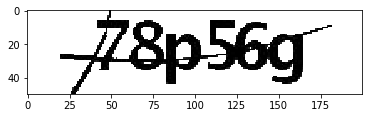

In [37]:
plt.imshow(flatimg, cmap=plt.cm.binary)

In [38]:
img = flatimg.copy()
img[:, :61] = 0
img = img[:, 50:]

In [39]:
img = np.hstack((img, np.repeat(0,2500).reshape(50,-1)))

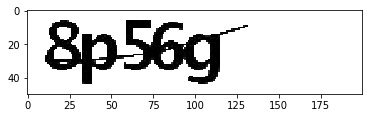

In [40]:
plt.imshow(img, cmap=plt.cm.binary)

In [41]:
img = img / 255.0
img = img.reshape(1, 50, 200, 1)

In [44]:
true = '8p56g'

onehotpred = np.array(model.predict(img)).reshape(5,36)    
pred = ''

for i in onehotpred:
    c = chars[np.argmax(i)]
    pred += c

#print(true, pred)